In [1]:
# environment setup
not.installed <- function(pkg) !is.element(pkg, installed.packages()[,1])
if (not.installed("nnet")) install.packages("nnet", repos="http://cran.us.r-project.org")
library(nnet)
if (not.installed("DAAG")) install.packages("DAAG", repos="http://cran.us.r-project.org")
library(DAAG)
if (not.installed("caret")) install.packages("caret", repos="http://cran.us.r-project.org")
library(caret)
if (not.installed("hydroGOF")) install.packages("hydroGOF", repos="http://cran.us.r-project.org")
library(hydroGOF)
if (not.installed("mlbench")) install.packages("mlbench", repos="http://cran.us.r-project.org")
library(mlbench)
if (not.installed("randomForest")) install.packages("randomForest", repos="http://cran.us.r-project.org")
library(randomForest)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [7]:
# load data
rawdata<-read.csv("network_backup_dataset.csv")
mydata<-data.frame(rawdata)

# transforming raw data into numeric data
Numeric.mydata = transform( mydata[, c(1,2,3,4,5,6,7)], Work.Flow.ID = unclass(Work.Flow.ID), File.Name = unclass(File.Name) )
Numeric.mydata$Day.of.Week <- ifelse(Numeric.mydata$Day.of.Week=='Monday',1,ifelse(Numeric.mydata$Day.of.Week=='Tuesday',2,ifelse(Numeric.mydata$Day.of.Week=='Wednesday',3,ifelse(Numeric.mydata$Day.of.Week=='Thursday',4,ifelse(Numeric.mydata$Day.of.Week=='Friday',5,ifelse(Numeric.mydata$Day.of.Week=='Saturday',6,ifelse(Numeric.mydata$Day.of.Week=='Sunday',7,0)))))))

# find the files for each workflow
flow1file<-unique(Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==1),]$File.Name)
flow2file<-unique(Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==2),]$File.Name)
flow3file<-unique(Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==3),]$File.Name)
flow4file<-unique(Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==4),]$File.Name)
flow5file<-unique(Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==5),]$File.Name)
workflow1<-Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==1),]
workflow2<-Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==2),]
workflow3<-Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==3),]
workflow4<-Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==4),]
workflow5<-Numeric.mydata[which(Numeric.mydata$Work.Flow.ID==5),]

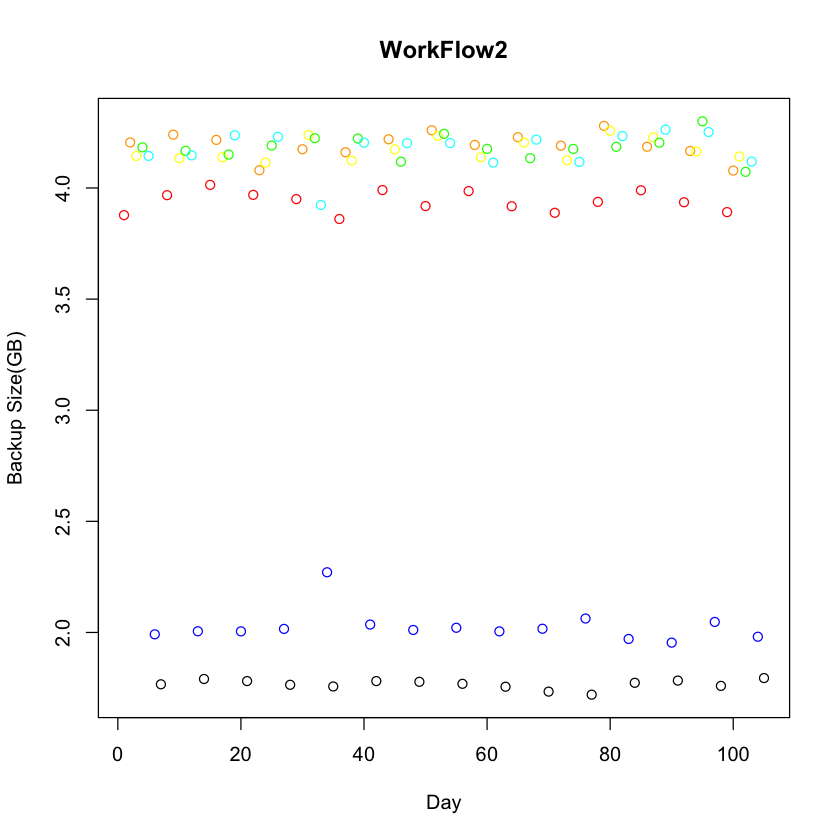

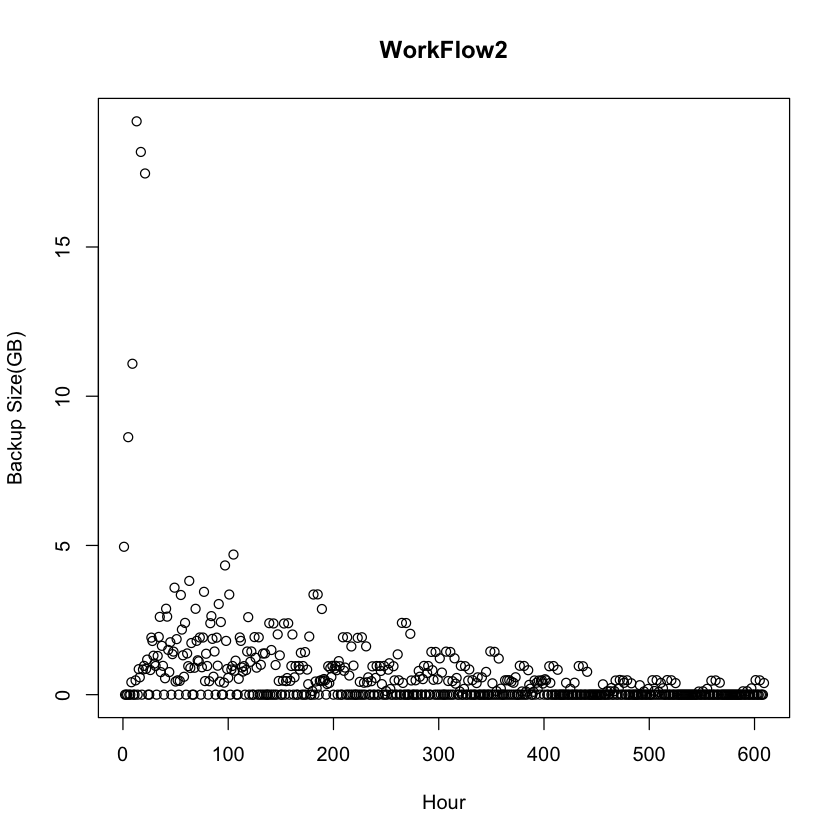

In [10]:
# plot the relationship of day/hour and total file size
color<-adjustcolor(c("red","orange","yellow","green","cyan","blue","black"), alpha=1)
day = c((workflow1$Week..-1)*7+workflow1$Day.of.Week)
sizePerDay = rep(0,max(day))
for(i in 1:length(day)){
    sizePerDay[(workflow1[i,]$Week..-1)*7+workflow1[i,]$Day.of.Week] = sizePerDay[(workflow1[i,]$Week..-1)*7+workflow1[i,]$Day.of.Week]+workflow1[i,]$Size.of.Backup..GB.
}
plot(sizePerDay, main="WorkFlow2", ylab="Backup Size(GB)", xlab="Day", col=color)
hour = c((workflow1$Week..-1)*7*(workflow1$Day.of.Week-1)+workflow1$Backup.Start.Time...Hour.of.Day)
sizePerHour = rep(0,max(hour))
for(i in 1:length(hour)){
    sizePerHour[(workflow1[i,]$Week..-1)*7*(workflow1[i,]$Day.of.Week-1)+workflow1[i,]$Backup.Start.Time...Hour.of.Day] = sizePerHour[(workflow1[i,]$Week..-1)*7*(workflow1[i,]$Day.of.Week-1)+workflow1[i,]$Backup.Start.Time...Hour.of.Day]+workflow1[i,]$Size.of.Backup..GB.
}
plot(sizePerHour, main="WorkFlow2", ylab="Backup Size(GB)", xlab="Hour")


Call:
lm(formula = Size.of.Backup..GB. ~ ., data = Numeric.mydata)

Coefficients:
                    (Intercept)                           Week..  
                     -0.0441479                        0.0001115  
                    Day.of.Week  Backup.Start.Time...Hour.of.Day  
                      0.0012019                        0.0009778  
                   Work.Flow.ID                        File.Name  
                      0.0024984                        0.0010337  
             Backup.Time..hour.  
                      0.0702075  



[1] 0.07904036

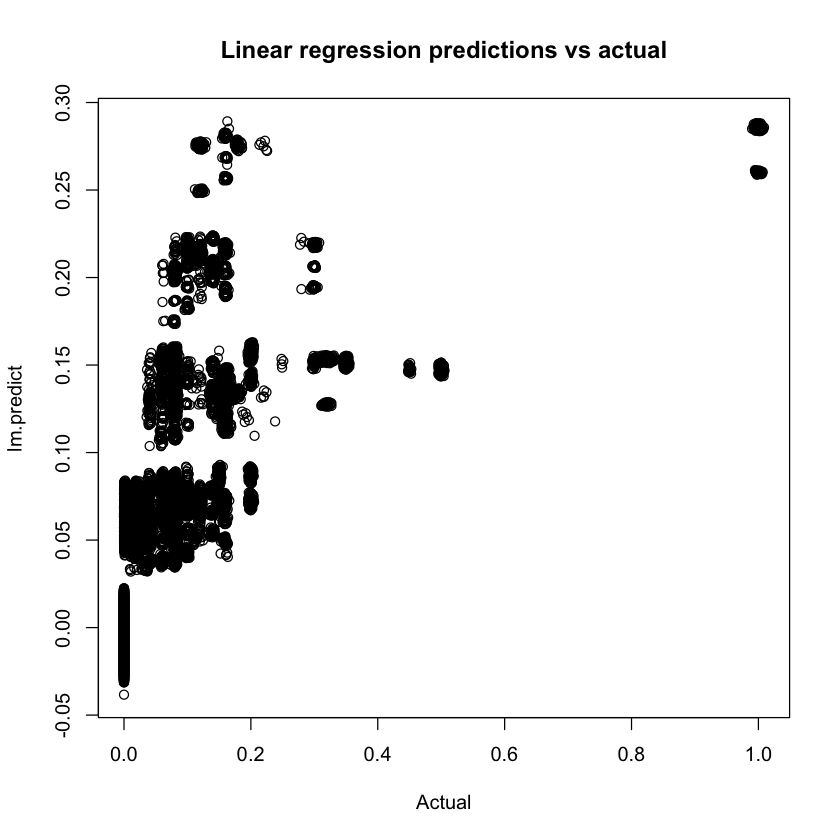

In [4]:
# simple linear regression
lm.fit <- lm(Size.of.Backup..GB. ~ ., data=Numeric.mydata)
print(lm.fit)
lm.predict <- predict(lm.fit)
sqrt(mean((lm.predict - Numeric.mydata$Size.of.Backup..GB.)^2))
plot(Numeric.mydata$Size.of.Backup..GB., lm.predict, main="Linear regression predictions vs actual", xlab="Actual")

In [5]:
# k-fold cross validation for linear regression
k.foldsLineaRegression <- function(k) {
    folds <- createFolds(Numeric.mydata$Size.of.Backup..GB., k = k, list = TRUE, returnTrain = TRUE)
    for (i in 1:k) {
        model <- lm(Size.of.Backup..GB. ~ ., data=Numeric.mydata[folds[[i]],])
        predictions <- predict(object=model, newdata=Numeric.mydata[-folds[[i]],])
        err <- c(err, rmse(predictions,Numeric.mydata[-folds[[i]],]$Size.of.Backup..GB.))
        print(summary(model))
    }
    err
}

set.seed(100)
err <- c()
err <- k.foldsLineaRegression(10)
err


Call:
lm(formula = Size.of.Backup..GB. ~ ., data = Numeric.mydata[folds[[i]], 
    ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.16122 -0.04398  0.00003  0.01796  0.74871 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -4.337e-02  2.639e-03 -16.435  < 2e-16 ***
Week..                           6.899e-05  1.393e-04   0.495     0.62    
Day.of.Week                      1.242e-03  3.036e-04   4.090 4.34e-05 ***
Backup.Start.Time...Hour.of.Day  9.736e-04  8.812e-05  11.049  < 2e-16 ***
Work.Flow.ID                     2.538e-03  4.266e-04   5.948 2.76e-09 ***
File.Name                        1.014e-03  7.063e-05  14.361  < 2e-16 ***
Backup.Time..hour.               6.956e-02  6.517e-04 106.734  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07779 on 16722 degrees of freedom
Multiple R-squared:  0.4261,	Adjusted R-squared:  0.4259 
F-stati

[1] 0.08964291 0.08684269 0.08186154 0.08221831 0.07253163 0.08522318
 [7] 0.06832791 0.06900666 0.07771504 0.07444102

                Length Class  Mode     
call                4  -none- call     
type                1  -none- character
predicted       18588  -none- numeric  
mse                80  -none- numeric  
rsq                80  -none- numeric  
oob.times       18588  -none- numeric  
importance          6  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               18588  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

[1] 0.01230398

,IncNodePurity
Week..,0.6138888
Day.of.Week,39.8669016
Backup.Start.Time...Hour.of.Day,20.9493786
Work.Flow.ID,29.6809116
File.Name,18.6215268
Backup.Time..hour.,81.0828831


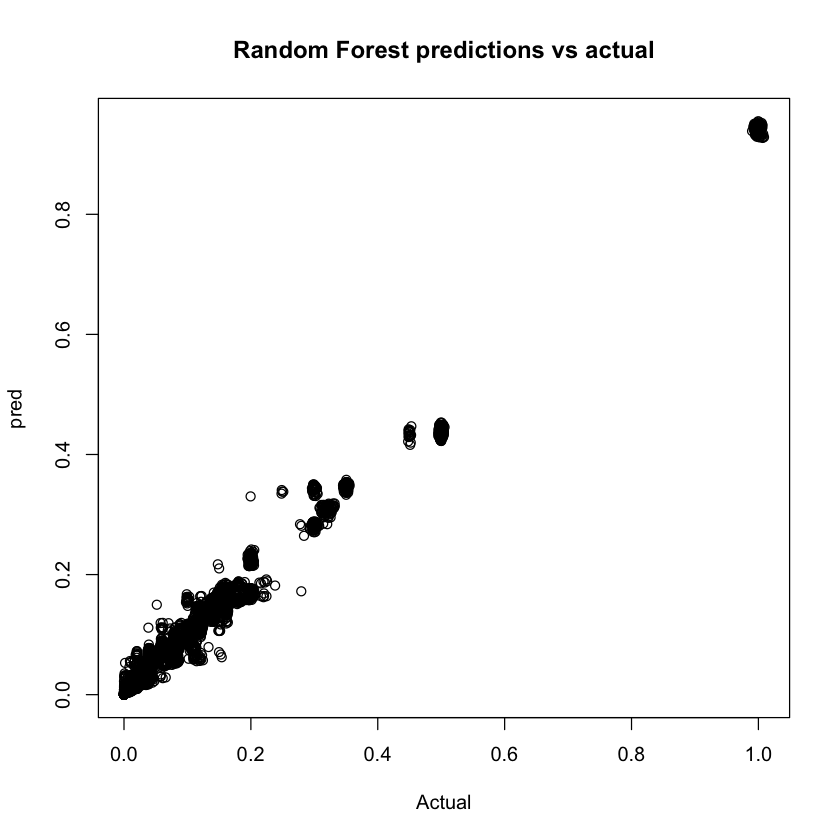

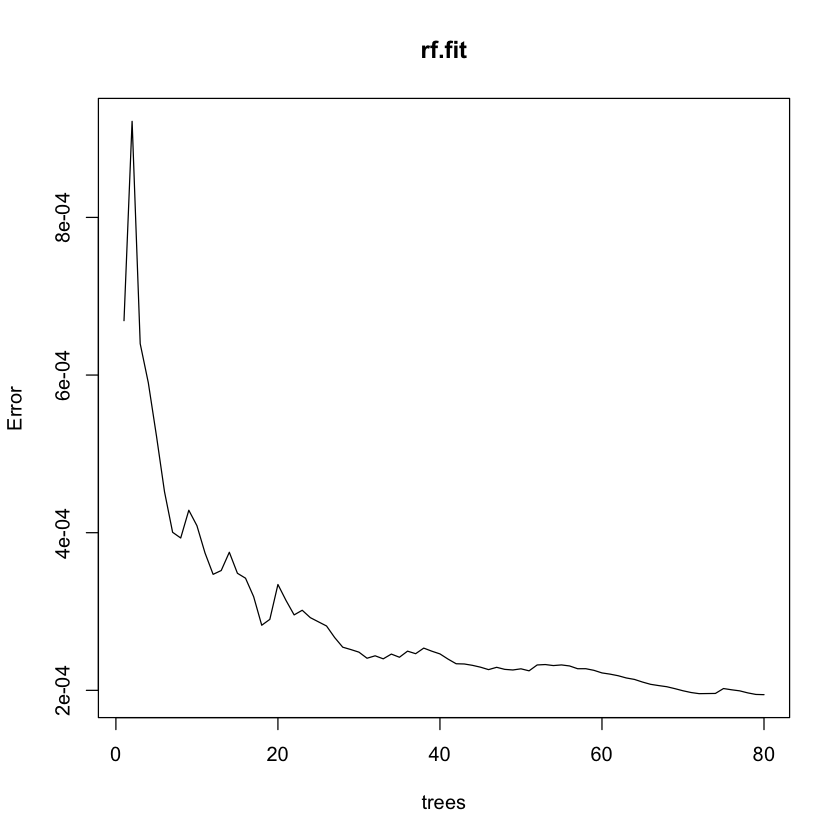

In [6]:
# random forest
rf.fit <- randomForest(Size.of.Backup..GB.~., data = Numeric.mydata, ntree=80)
summary(rf.fit)
pred = predict(rf.fit, Numeric.mydata)
sqrt(mean((pred - Numeric.mydata$Size.of.Backup..GB.)^2))
plot(Numeric.mydata$Size.of.Backup..GB., pred, main="Random Forest predictions vs actual", xlab="Actual")
importance(rf.fit)
plot(rf.fit)

In [9]:
k.foldsRandomForest <- function(k) {
    folds <- createFolds(Numeric.mydata$Size.of.Backup..GB., k = k, list = TRUE, returnTrain = TRUE)
    for (i in 1:k) {
        model <- randomForest(Size.of.Backup..GB. ~ ., data=Numeric.mydata[folds[[i]],], ntree=60)
        predictions <- predict(object=model, newdata=Numeric.mydata[-folds[[i]],])
        err <- c(err, rmse(predictions,Numeric.mydata[-folds[[i]],]$Size.of.Backup..GB.))
        print(summary(model))
    }
    err
}

set.seed(100)
err <- c()
err <- k.foldsRandomForest(10)
err

                Length Class  Mode     
call                4  -none- call     
type                1  -none- character
predicted       16729  -none- numeric  
mse                60  -none- numeric  
rsq                60  -none- numeric  
oob.times       16729  -none- numeric  
importance          6  -none- numeric  
importanceSD        0  -none- NULL     
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               16729  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     
                Length Class  Mode     
call                4  -none- call     
type                1  -none- character
predicted       16730  -none- numeric  
mse                60  -none- numeric  
rsq                60  -none- numeric  


[1] 0.01287125 0.01375522 0.01402688 0.01303335 0.01195248 0.01371539
 [7] 0.01400668 0.01201569 0.01240954 0.01301206

# weights:  81
initial  value 7740.519144 
iter  10 value 178.873874
iter  20 value 136.044080
iter  30 value 118.150927
iter  40 value 102.447497
iter  50 value 84.041056
iter  60 value 61.084786
iter  70 value 52.195968
iter  80 value 47.923099
iter  90 value 41.033412
iter 100 value 37.530751
final  value 37.530751 
stopped after 100 iterations


a 6-10-1 network with 81 weights
options were - linear output units 
 b->h1 i1->h1 i2->h1 i3->h1 i4->h1 i5->h1 i6->h1 
  0.54  -0.04   0.08  -0.06  -0.44  -0.14  -0.06 
 b->h2 i1->h2 i2->h2 i3->h2 i4->h2 i5->h2 i6->h2 
  2.08   0.83   1.02   0.33   2.20  -1.44  -1.38 
 b->h3 i1->h3 i2->h3 i3->h3 i4->h3 i5->h3 i6->h3 
 -1.67   0.01  -0.77   0.00   1.19   0.01   1.00 
 b->h4 i1->h4 i2->h4 i3->h4 i4->h4 i5->h4 i6->h4 
 -1.71  -0.01   1.53   0.02  -1.23   0.00  -0.43 
 b->h5 i1->h5 i2->h5 i3->h5 i4->h5 i5->h5 i6->h5 
  0.16   0.07   0.01  -0.01  -0.26   0.24   1.21 
 b->h6 i1->h6 i2->h6 i3->h6 i4->h6 i5->h6 i6->h6 
 -0.35   0.06  -0.79   1.80  -1.24   0.43  -3.98 
 b->h7 i1->h7 i2->h7 i3->h7 i4->h7 i5->h7 i6->h7 
 -0.33   0.00   0.19  -0.04   1.28   0.02   0.09 
 b->h8 i1->h8 i2->h8 i3->h8 i4->h8 i5->h8 i6->h8 
  2.67   0.01   4.44  -0.05  -0.15   0.00  -1.86 
 b->h9 i1->h9 i2->h9 i3->h9 i4->h9 i5->h9 i6->h9 
 -1.35   0.35   0.97  -1.45  -3.96   1.64   0.51 
 b->h10 i1->h10 i2->h10 i3->h10

[1] 0.04493423

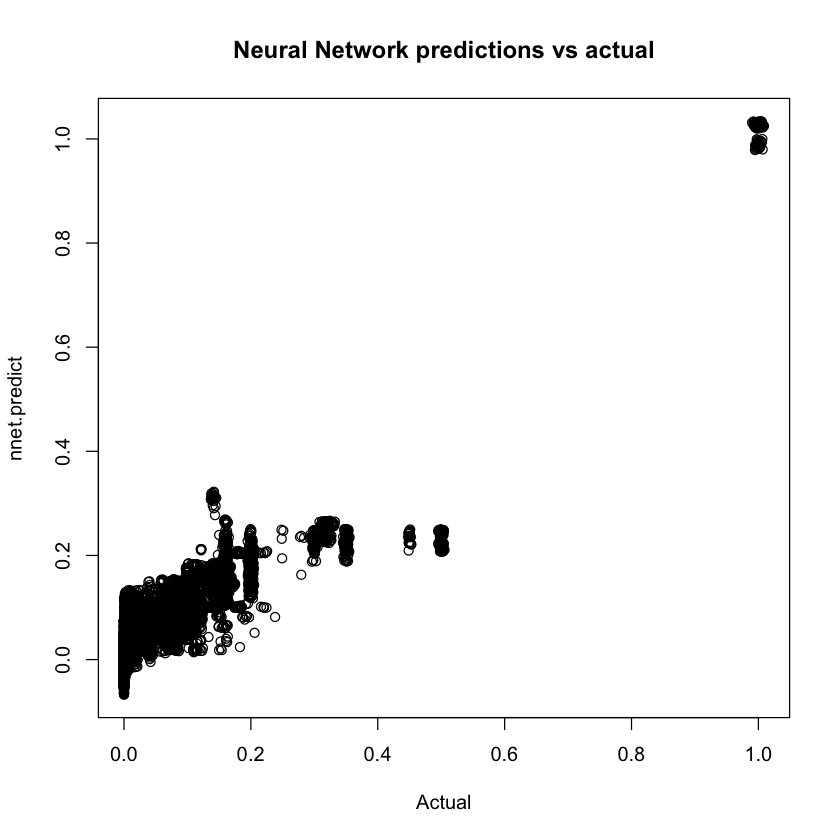

In [10]:
# neural network
nnet.fit <- nnet(Size.of.Backup..GB. ~ ., data=Numeric.mydata, size=10, linout=TRUE)
summary(nnet.fit)
nnet.predict <- predict(nnet.fit)
sqrt(mean((nnet.predict - Numeric.mydata$Size.of.Backup..GB.)^2))
plot(Numeric.mydata$Size.of.Backup..GB., nnet.predict, main="Neural Network predictions vs actual", xlab="Actual")

In [15]:
# polynomial fitting (Day.of.Week)
set.seed(100)
train_index <- createDataPartition(Numeric.mydata$Size.of.Backup..GB., p = .8, list = FALSE)
trainset <- Numeric.mydata[train_index, ]
testset <- Numeric.mydata[-train_index, ]
rmse_value <- c()
for(i in 1:6) {
    poly_model <- lm(Size.of.Backup..GB. ~ poly(Day.of.Week,i), data = trainset)
    poly_pred <- predict(poly_model, testset)
    err <- postResample(pred = poly_pred, obs = testset$Size.of.Backup..GB.)
    rmse_value <- c(rmse_value, err['RMSE'])
}
rmse_value

RMSE      RMSE      RMSE      RMSE      RMSE      RMSE 
0.1039063 0.1035231 0.1028381 0.1028535 0.1028373 0.1028113

In [16]:
# polynomial fitting (Backup.Start.Time...Hour.of.Day)
set.seed(100)
train_index <- createDataPartition(Numeric.mydata$Size.of.Backup..GB., p = .8, list = FALSE)
trainset <- Numeric.mydata[train_index, ]
testset <- Numeric.mydata[-train_index, ]
rmse_value <- c()
for(i in 1:5) {
    poly_model <- lm(Size.of.Backup..GB. ~ poly(Backup.Start.Time...Hour.of.Day,i), data = trainset)
    poly_pred <- predict(poly_model, testset)
    err <- postResample(pred = poly_pred, obs = testset$Size.of.Backup..GB.)
    rmse_value <- c(rmse_value, err['RMSE'])
}
rmse_value

RMSE      RMSE      RMSE      RMSE      RMSE 
0.1037149 0.1031444 0.1030646 0.1024465 0.1024537

RMSE       RMSE       RMSE       RMSE 
0.10385315 0.09369050 0.09243439 0.09193637

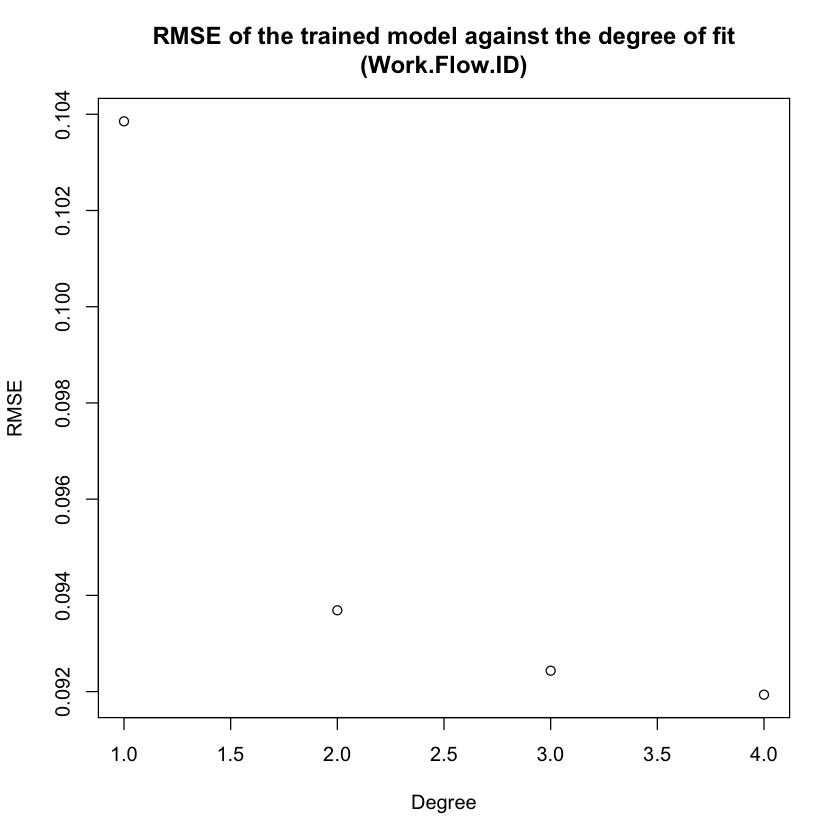

In [33]:
# polynomial fitting (Work.Flow.ID)
set.seed(100)
train_index <- createDataPartition(Numeric.mydata$Size.of.Backup..GB., p = .8, list = FALSE)
trainset <- Numeric.mydata[train_index, ]
testset <- Numeric.mydata[-train_index, ]
rmse_value <- c()
for(i in 1:4) {
    poly_model <- lm(Size.of.Backup..GB. ~ poly(Work.Flow.ID,i), data = trainset)
    poly_pred <- predict(poly_model, testset)
    err <- postResample(pred = poly_pred, obs = testset$Size.of.Backup..GB.)
    rmse_value <- c(rmse_value, err['RMSE'])
}
rmse_value
plot(c(1:4),rmse_value, main="RMSE of the trained model against the degree of fit\n(Work.Flow.ID)", ylab="RMSE", xlab="Degree")

RMSE       RMSE       RMSE       RMSE       RMSE       RMSE       RMSE 
0.10319474 0.10322879 0.09704644 0.09701797 0.09663909 0.09568604 0.09570989 
      RMSE       RMSE       RMSE       RMSE       RMSE       RMSE       RMSE 
0.09506766 0.09507539 0.09494862 0.09486084 0.09426782 0.09414263 0.09411805 
      RMSE       RMSE       RMSE       RMSE       RMSE       RMSE 
0.09394396 0.09368982 0.09369413 0.09335396 0.09317288 0.09306211

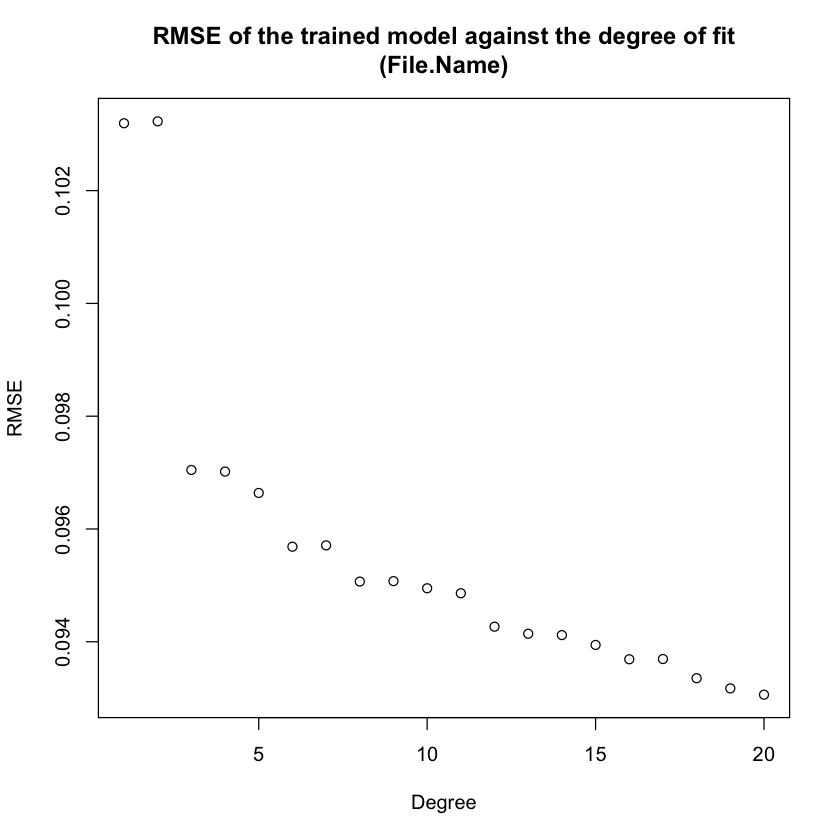

In [28]:
# polynomial fitting (File.Name)
set.seed(100)
train_index <- createDataPartition(Numeric.mydata$Size.of.Backup..GB., p = .8, list = FALSE)
trainset <- Numeric.mydata[train_index, ]
testset <- Numeric.mydata[-train_index, ]
rmse_value <- c()
for(i in 1:20) {
    poly_model <- lm(Size.of.Backup..GB. ~ poly(File.Name,i), data = trainset)
    poly_pred <- predict(poly_model, testset)
    err <- postResample(pred = poly_pred, obs = testset$Size.of.Backup..GB.)
    rmse_value <- c(rmse_value, err['RMSE'])
}
rmse_value
plot(c(1:20),rmse_value, main="RMSE of the trained model against the degree of fit\n(File.Name)", ylab="RMSE", xlab="Degree")

In [42]:
k.foldsPolyRegression <- function(k) {
    folds <- createFolds(Numeric.mydata$Size.of.Backup..GB., k = k, list = TRUE, returnTrain = TRUE)
    for (i in 1:k) {
        model <- lm(Size.of.Backup..GB. ~ poly(Backup.Time..hour.,4), data=Numeric.mydata[folds[[i]],])
#         model <- lm(Size.of.Backup..GB. ~ poly(c,20), data=Numeric.mydata[folds[[i]],])
#         model <- lm(Size.of.Backup..GB. ~ poly(Work.Flow.ID,4), data=Numeric.mydata[folds[[i]],])
        predictions <- predict(object=model, newdata=Numeric.mydata[-folds[[i]],])
        err <- c(err, rmse(predictions,Numeric.mydata[-folds[[i]],]$Size.of.Backup..GB.))
        print(summary(model))
    }
    err
}

set.seed(100)
err <- c()
err <- k.foldsPolyRegression(10)
err


Call:
lm(formula = Size.of.Backup..GB. ~ poly(Backup.Time..hour., 4), 
    data = Numeric.mydata[folds[[i]], ])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.27467 -0.03329  0.00000  0.00447  0.62235 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.0606155  0.0005786  104.76   <2e-16 ***
poly(Backup.Time..hour., 4)1 8.5276142  0.0748400  113.94   <2e-16 ***
poly(Backup.Time..hour., 4)2 0.7581123  0.0748400   10.13   <2e-16 ***
poly(Backup.Time..hour., 4)3 0.7274183  0.0748400    9.72   <2e-16 ***
poly(Backup.Time..hour., 4)4 2.9740870  0.0748400   39.74   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07484 on 16724 degrees of freedom
Multiple R-squared:  0.4688,	Adjusted R-squared:  0.4687 
F-statistic:  3690 on 4 and 16724 DF,  p-value: < 2.2e-16


Call:
lm(formula = Size.of.Backup..GB. ~ poly(Backup.Time..hour., 4), 
    data = Numeric.mydat

[1] 0.08494778 0.08276961 0.07691680 0.07705225 0.07129082 0.08156527
 [7] 0.06872242 0.06840467 0.07444839 0.07208440

In [57]:
#  dropping the feature Work.Flow.ID
workflow1$Work.Flow.ID<-NULL
workflow2$Work.Flow.ID<-NULL
workflow3$Work.Flow.ID<-NULL
workflow4$Work.Flow.ID<-NULL
workflow5$Work.Flow.ID<-NULL

In [69]:
# Predict backup size of each workflow
# simple linear regression
# lm.fit <- lm(Size.of.Backup..GB. ~ ., data=workflow5)
# print(lm.fit)
# lm.predict <- predict(lm.fit)
# sqrt(mean((lm.predict - workflow5$Size.of.Backup..GB.)^2))
# plot(workflow5$Size.of.Backup..GB., lm.predict, main="Linear regression predictions vs actual", xlab="Actual")
# # linear regression cross validation
# k.foldsLineaRegression <- function(k) {
#     folds <- createFolds(workflow5$Size.of.Backup..GB., k = k, list = TRUE, returnTrain = TRUE)
#     for (i in 1:k) {
#         model <- lm(Size.of.Backup..GB. ~ ., data=workflow5[folds[[i]],])
#         predictions <- predict(object=model, newdata=workflow5[-folds[[i]],])
#         err <- c(err, rmse(predictions,workflow5[-folds[[i]],]$Size.of.Backup..GB.))
#         print(summary(model))
#     }
#     err
# }
# set.seed(100)
# err <- c()
# err <- k.foldsLineaRegression(10)
# err
# generalization RMSE
# folds <- createFolds(workflow5$Size.of.Backup..GB., k = 10, list = TRUE, returnTrain = TRUE)
# model <- lm(Size.of.Backup..GB. ~ ., data=workflow5[folds[[2]],])
# predictions <- predict(object=model, newdata=workflow5[-folds[[2]],])
# rmse(predictions,workflow5[-folds[[2]],]$Size.of.Backup..GB.)


[1] 0.08628105